In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
dwnload_file = drive.CreateFile({'id':'1urHYahb9NlEWNBOHJXrNg_RCmqOvQNZH'}) #'1TeCPI8sdja_24nvjfsAUe6YgZyQRwBt2'})


In [ ]:
dwnload_file.GetContentFile('shelves_relevant.csv')

In [ ]:
import pandas as pd
shelves_relevant = pd.read_csv('shelves_relevant.csv')
shelves_relevant.dropna(axis = 0, inplace = True)
shelves_relevant.shape

(546097, 14)

In [ ]:
# Focus on the explanatory variables
x = ['upc_description', 'storenum', 'wks']
X = shelves_relevant.drop(['logistic_target', 'target_out_stock','year', 'upc', 'new_year_mth_wk', 'profit_unit', 'retail_price_unit'], axis = 1, inplace = False)
X.dropna(axis  = 0, inplace = True)
X_grouped = X.groupby(x) # groupedby object - grouping on 'upc_description', 'storenum', 'wks'
#len(X_grouped.groups.keys())
#[['gross_margin_dollars', 'scanned_retail_dollars','scanned_movement',  'scanned_retail_dollars:scanned_movement']]

#mean_amts = X_grouped[['gross_margin_dollars', 'scanned_retail_dollars','scanned_movement',  'scanned_retail_dollars:scanned_movement']].apply(lambda u: (u - u.mean())/u.std())
mean_amts = X_grouped.mean()
mean_amts.reset_index(inplace = True)
mean_amts.dropna(axis = 0, how = 'any', inplace = True)
#mean_amts.index
print(mean_amts.head(), mean_amts.shape)


             upc_description  storenum  wks  gross_margin_dollars  \
0  10 BARL CRSH SMPL 12P CAN       803  WK1              8.798750   
1  10 BARL CRSH SMPL 12P CAN       803  WK2              7.405000   
2  10 BARL CRSH SMPL 12P CAN       803  WK3             11.767143   
3  10 BARL CRSH SMPL 12P CAN       803  WK4              8.344286   
4  10 BARL CRSH SMPL 12P CAN       807  WK1             11.660000   

   scanned_retail_dollars  scanned_movement  \
0               31.486250          1.375000   
1               26.655000          1.166667   
2               42.410000          1.857143   
3               29.558571          1.285714   
4               47.910667          2.266667   

   scanned_retail_dollars:scanned_movement  
0                                48.603750  
1                                34.318333  
2                                94.387143  
3                                42.695714  
4                               167.850667   (21648, 7)


In [ ]:
mean_amts.index


RangeIndex(start=0, stop=21648, step=1)

In [ ]:
# Import OneHotEnCoder to use in construction of a Design Matrix
import sklearn
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop = 'first') # instantiation
ohe_rslts = ohe.fit_transform(mean_amts[['wks', 'upc_description', 'storenum']])
colnames = list(mean_amts['wks'].unique()[1:]) + list(mean_amts['upc_description'].unique()[1:])+ ["st" + str(x) for x in list(mean_amts['storenum'].unique()[1:])]
br_st_wk = pd.DataFrame(ohe_rslts.toarray(),columns = colnames )
br_st_wk = br_st_wk.dropna(axis = 0) # in fact all rows are non-empty

#br_st_wk.dropna(axis = 0, inplace = False)
#br_st_wk.index = mean_amts.index
br_st_wk.index


RangeIndex(start=0, stop=21648, step=1)

In [ ]:
x = ['upc_description', 'storenum', 'wks']
y = shelves_relevant[['upc_description', 'storenum', 'wks', 'target_out_stock']].groupby(x,axis = 0).mean()
y.reset_index(inplace = True)
y.dropna(axis = 0, how = 'any', inplace = True)
y.index

RangeIndex(start=0, stop=21648, step=1)

In [ ]:
z_right = mean_amts[['gross_margin_dollars', 'scanned_retail_dollars', 'scanned_movement', 'scanned_retail_dollars:scanned_movement']].head()
z_right

,gross_margin_dollars,scanned_retail_dollars,scanned_movement,scanned_retail_dollars:scanned_movement
0,8.798750,31.486250,1.375000,48.603750
1,7.405000,26.655000,1.166667,34.318333
2,11.767143,42.410000,1.857143,94.387143
3,8.344286,29.558571,1.285714,42.695714
4,11.660000,47.910667,2.266667,167.850667


In [ ]:
z_left = br_st_wk.head()
z_left



,WK2,WK3,WK4,10 BARREL APCLYPS 6PK BTL,10 BARREL APCLYPS IPA BTL,10 BARREL APOCLYPS 6P CAN,10 BARREL JOE IPA 6P BTL,10 BARREL MIX 12PK BTL,10 BARREL PEARL 6P CAN,10 BARREL SEASONAL BTL,...,st824,st827,st828,st826,st894,st855,st859,st870,st106,st805
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
br_st_wk.merge(mean_amts[['gross_margin_dollars', 'scanned_retail_dollars', 'scanned_movement', 'scanned_retail_dollars:scanned_movement']], how = 'inner', left_index =True, right_index = True)

,WK2,WK3,WK4,10 BARREL APCLYPS 6PK BTL,10 BARREL APCLYPS IPA BTL,10 BARREL APOCLYPS 6P CAN,10 BARREL JOE IPA 6P BTL,10 BARREL MIX 12PK BTL,10 BARREL PEARL 6P CAN,10 BARREL SEASONAL BTL,...,st894,st855,st859,st870,st106,st805,gross_margin_dollars,scanned_retail_dollars,scanned_movement,scanned_retail_dollars:scanned_movement
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.798750,31.486250,1.375000,48.603750
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.405000,26.655000,1.166667,34.318333
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.767143,42.410000,1.857143,94.387143
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.344286,29.558571,1.285714,42.695714
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.660000,47.910667,2.266667,167.850667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21643,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,14.525833,4.916667,98.329167
21644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,92.458947,9.368421,1016.735786
21645,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,99.981667,10.166667,1191.563890
21646,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,98.343889,10.055556,1023.591667


In [ ]:
#merge the  datasets : mean_amts, br_st_wks

X = br_st_wk.merge(mean_amts[['gross_margin_dollars', 'scanned_retail_dollars', 'scanned_movement', 'scanned_retail_dollars:scanned_movement']], how = 'inner' , left_index = True, right_index = True)

y_response = br_st_wk.merge(y[['target_out_stock']], how = 'inner' , left_index = True, right_index = True)


   WK2  WK3  WK4  10 BARREL APCLYPS 6PK BTL  10 BARREL APCLYPS IPA BTL  \
0  0.0  0.0  0.0                        0.0                        0.0   
1  1.0  0.0  0.0                        0.0                        0.0   
2  0.0  1.0  0.0                        0.0                        0.0   
3  0.0  0.0  1.0                        0.0                        0.0   
4  0.0  0.0  0.0                        0.0                        0.0   

   10 BARREL APOCLYPS 6P CAN  10 BARREL JOE IPA 6P BTL  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        0.0                       0.0   
4                        0.0                       0.0   

   10 BARREL MIX 12PK BTL  10 BARREL PEARL 6P CAN  10 BARREL SEASONAL BTL  \
0                     0.0                     0.0                     0.0   
1                     0.0                     0.0   

In [ ]:
# Create Train and Test sets
from sklearn.model_selection import train_test_split

X_train, X_test , y_train, y_test  = sklearn.model_selection.train_test_split(X, y_response, test_size = .1, random_state = 100, stratify = None)

In [ ]:
print( X_train.head())

       key_0  WK2  WK3  WK4  10 BARREL APCLYPS 6PK BTL  \
14638  14638  1.0  0.0  0.0                        0.0   
10986  10986  0.0  1.0  0.0                        0.0   
12056  12056  1.0  0.0  0.0                        0.0   
11482  11482  0.0  1.0  0.0                        0.0   
6329    6329  1.0  0.0  0.0                        0.0   

       10 BARREL APCLYPS IPA BTL  10 BARREL APOCLYPS 6P CAN  \
14638                        0.0                        0.0   
10986                        0.0                        0.0   
12056                        0.0                        0.0   
11482                        0.0                        0.0   
6329                         0.0                        0.0   

       10 BARREL JOE IPA 6P BTL  10 BARREL MIX 12PK BTL  \
14638                       0.0                     0.0   
10986                       0.0                     0.0   
12056                       0.0                     0.0   
11482                       0.0     

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [ ]:
y_train.to_csv('/content/gdrive/My Drive/Beer/yspl_train.csv' ,index = False)
y_test.to_csv('/content/gdrive/My Drive/Beer/yspl_test.csv', index = False)
X_train.to_csv('/content/gdrive/My Drive/Beer/X_train.csv', index = False)
X_test.to_csv('/content/gdrive/My Drive/Beer/X_test.csv', index = False)

In [ ]:
import math
import numpy as np
target_train = np.ceil(y_train['target_out_stock'])
target_test = np.ceil(y_test['target_out_stock'])
max(target_train)

4.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


(19483, 777) Int64Index([14638, 10986, 12056, 11482,  6329,  1469, 16797, 13158,  8927,
            16356,
            ...
            13890, 20533, 10082, 14260, 16734, 16304,    79, 12119, 14147,
             5640],
           dtype='int64', length=19483)
(19483, 778)
(19483, 778)


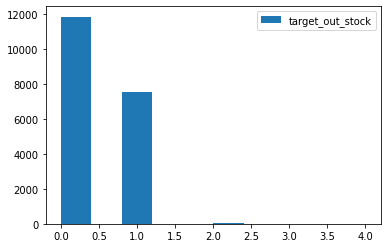

In [ ]:
import numpy as np
import statsmodels.api as sm

X_train_w_intcept = sm.add_constant(X_train)


print(X_train_w_intcept.shape, target_train.index)
a = X_train_w_intcept.merge(target_train.to_frame(), how  = 'inner',left_index = True, right_index = True)
print(a.shape)
b = a.dropna(axis = 0)
print(b.shape)

import matplotlib.pyplot as plt
fig , ax = plt.subplots()
ax.hist(target_train, bins = 10, label = 'target_out_stock')
ax.legend()
plt.show()

In [ ]:
# Checking the non-singularity of the Design Matrix
poisson_model = sm.GLM(np.array(target_train), np.array(X_train_w_intcept), family=sm.families.Poisson())
u, s, vt = np.linalg.svd(poisson_model.exog, 0)

print(min(s))

# Note : A singular value (last in the diagonal matrix) is small ( ~ e-3)
# we may try the 'elastic_net' method -- related to ridge regression thereby introducing some bias.


0.0063269597275408245


In [ ]:
dir(poisson_model.fit_regularized)


['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [ ]:
poisson_results = poisson_model.fit_regularized(method = "elastic_net", alpha = .1, maxiter = 500)   # fit(max_iter = 500) #

dir(poisson_results)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_data_attr',
 '_data_in_cache',
 'converged',
 'fittedvalues',
 'initialize',
 'k_constant',
 'model',
 'params',
 'predict',
 'summary']

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


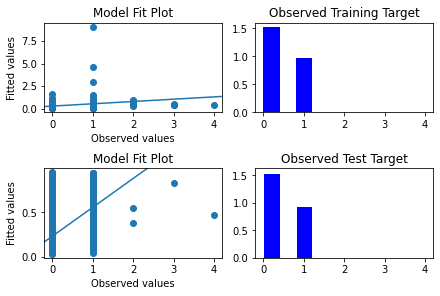

In [ ]:
yhat = poisson_results.fittedvalues
#max_yhat =yhat.max()
from statsmodels.graphics.api import abline_plot
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True
fig, ax = plt.subplots(2,2)

ax[0, 0].scatter(target_train, yhat)
line_fit_train = sm.OLS(target_train, sm.add_constant(yhat, prepend = True)).fit()
abline_plot(model_results=line_fit_train, ax=ax[0,0])
ax[0, 0].set_title('Model Fit Plot')
ax[0, 0].set_xlabel('Observed values')
ax[0, 0].set_ylabel('Fitted values')
n_bins = 10
ax[0, 1].hist(target_train, bins = n_bins, density = True, color = 'blue')
ax[0, 1].set_title("Observed Training Target")

X_w_intcept_test = sm.add_constant(X_test)
y_pred_test = poisson_results.predict(X_w_intcept_test)

ax[1, 0].scatter(target_test, y_pred_test)
line_fit_test = sm.OLS(target_test, sm.add_constant(y_pred_test, prepend = True)).fit()
abline_plot(model_results=line_fit_test, ax=ax[1,0])

ax[1, 0].set_title('Model Fit Plot')
ax[1, 0].set_xlabel('Observed values')
ax[1, 0].set_ylabel('Fitted values')
n_bins = 10
#ax[1, 1].hist(y_usw_pred_test, bins = 10, density = True, color = None)
ax[1,1].set_title("Observed Test Target")
ax[1, 1].hist(target_test, bins = n_bins, density = True, edgecolor = 'white', color = 'blue')
plt.show()


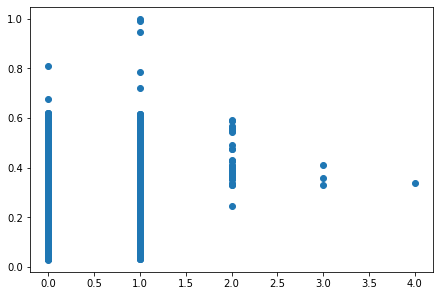

In [ ]:
import math
import matplotlib.pyplot as plt
X_train_w_intcept['est_prob'] = np.ones(len(yhat)) - np.exp(-yhat)
fig , ax = plt.subplots()

ax.scatter(target_train, X_train_w_intcept['est_prob'])
plt.show()





Text(0, 0.5, 'True Positive Rate')

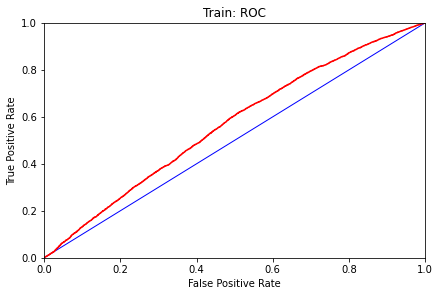

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import  roc_curve
#from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
train_binary = [x > 0 for x in target_train]
fpr,  tpr, _ = roc_curve(train_binary, X_train_w_intcept['est_prob'])

fig, ax = plt.subplots()
ax.plot([0, 1],[0, 1], lw = 1, color = 'blue')
ax.plot(fpr, tpr, color = 'red')
plt.ylim([0, 1.0])
plt.xlim([0, 1])
ax.set_title("Train: ROC")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

#roc_curve_display = RocCurveDisplay(fpr = fpr, tpr = tpr).plot()


Introducing the Tweedie Model
1) Initially choose a distribution based on the mean_tweedie_deviance
2) Try a Poisson model to compare with the previous results
3) To calculate the mean_tweedie_deviation, the numeric data is standardized.

In [ ]:
#from sklearn.datasets import make_classification
from sklearn.linear_model import TweedieRegressor
#from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#X, y = make_classification(random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipe = make_pipeline(StandardScaler(), TweedieRegressor(fit_intercept = True, power = 1.2))
print(dir(pipe))
pipe.fit(X_train, target_train)  # apply scaling on training data


pipe.score(X_test, target_test)  # apply scaling on testing data, without leaking training data.


['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_is_fitted__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_can_inverse_transform', '_can_transform', '_check_feature_names', '_check_fit_params', '_check_n_features', '_estimator_type', '_final_estimator', '_fit', '_get_param_names', '_get_params', '_get_tags', '_iter', '_log_message', '_more_tags', '_pairwise', '_replace_estimator', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_required_parameters', '_set_params', '_sk_visual_block_', '_validate_data', '_validate_names', '_validate_steps', 'classes_', 'decision_function', 'feature_names_in_', 'fit', 'fit_

0.1340075253183951

In [ ]:
# Exploring various power ( variance power or "tweedie_power") options for the Tweedie Distribution
# Calculating the deviances that result from the model that uses each 'power' number  in "tweedie_power"
from sklearn import linear_model
from sklearn.metrics import mean_tweedie_deviance
from sklearn.pipeline import make_pipeline
tweedie_power = [0, 1, 1.2, 1.4,  1.5,  1.7, 1.9]

dev = []
for tp in tweedie_power:
     clf = make_pipeline(StandardScaler(), linear_model.TweedieRegressor(fit_intercept =True, power = tp, max_iter = 100))
     clf.fit(X_train, target_train)
     y_tw_pred = clf.predict(X_train)

     dev.append(mean_tweedie_deviance(target_train, y_tw_pred, power = tp))
dev

[0.17950222314104144,
 0.6292762045521139,
 0.8651483485672284,
 1.2832374299119025,
 1.6330329111625719,
 3.1076484461622886,
 10.986438850314002]

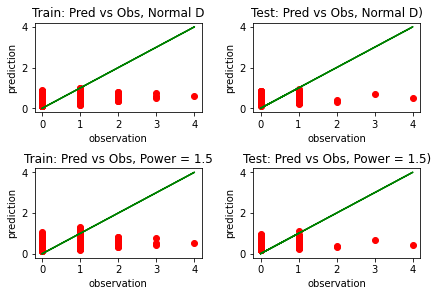

In [ ]:
# The Normal Distribution ( variance_power = 0) has the lowest deviance
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True
fig, ax = plt.subplots(2,2)

#for tp in tweedie_power:
for r in range(0, 2):
     dist_name = ['Normal D', 'Power = 1.5']
     clf = make_pipeline(StandardScaler(), linear_model.TweedieRegressor(fit_intercept = True, power = r*1.5))
     clf.fit(X_train, target_train)
     y_tw_pred_trn = clf.predict(X_train)

     ax[r,0].plot(target_train, y_tw_pred_trn, 'o', color = 'red')

     ax[r, 0].plot(target_train,target_train, color = 'green')
     ax[r, 0].set_ylabel("prediction")
     ax[r, 0].set_xlabel("observation")
     ax[r, 0].set_title(f"Train: Pred vs Obs, {dist_name[r]}")


     y_tw_pred_tst = clf.predict(X_test)

     ax[r,1].plot(target_test, y_tw_pred_tst, 'o', color = 'red')

     ax[r,1].plot(target_test, target_test, color = 'green')
     ax[r,1].set_ylabel("prediction")
     ax[r,1].set_xlabel("observation")
     ax[r,1].set_title(f"Test: Pred vs Obs, {dist_name[r]})")

plt.show()


In [ ]:
#AdaBoost Regression - Ensemble Method
from sklearn.ensemble import AdaBoostRegressor
mean_square = []
len_test = target_test.shape[0]
for n_est in range(10, 60, 2):
    ada_regr = AdaBoostRegressor(learning_rate = 1.1, n_estimators = n_est, random_state = 170, loss = 'square')
    ada_regr.fit(X_train, target_train)
    #y_ada_pred_trn = ada_regr.predict(X_usw_mdl_train)
    y_ada_pred_tst = ada_regr.predict(X_test)
    u = [x**2 for x in list(np.array(y_ada_pred_tst) - np.array(target_test))]
    mean_square.append((1/len_test)*sum(u))

print(f'The mean squared error on the test set is {mean_square}')




The mean squared error on the test set is [0.1684718680859955, 0.16830610208046992, 0.17132750957952253, 0.17667576779259384, 0.17744144624754168, 0.1882416639603002, 0.20066462428235746, 0.20143484291315736, 0.20789271682364513, 0.21272006270760876, 0.21633182653209068, 0.21887218409666398, 0.22697263575974871, 0.24276024641799188, 0.2660500880026283, 0.2992942217543866, 0.31043139576593437, 0.32620203188793245, 0.3360904334331017, 0.33851460599039684, 0.3413552635160934, 0.3534932333381315, 0.36131352050573873, 0.37824100326420684, 0.38202749180830453]


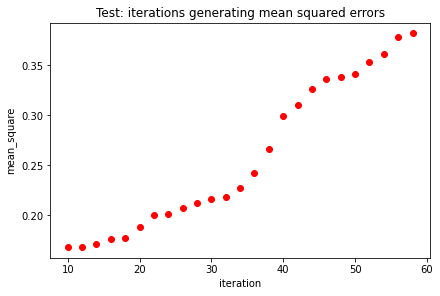

In [ ]:
import matplotlib.pyplot as plt
#plt.rcParams['figure.constrained_layout.use'] = True # Separates the plots --- allows the labels on the axes to be read.
fig, ax = plt.subplots()
ax.plot(range(10, 60, 2), mean_square, 'o', color = 'red')

ax.set_ylabel("mean_square")
ax.set_xlabel("iteration")
ax.set_title("Test: iterations generating mean squared errors")

plt.show()


In [ ]:
# Cross-Validation for
# 1) AdaBoost Regression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
#AdaBoost Regression - Ensemble Method
from sklearn.ensemble import AdaBoostRegressor
ada_regr = AdaBoostRegressor(learning_rate = 1.1, n_estimators = 7, random_state = 170, loss = 'square')
cross_val_score(ada_regr, X_train, target_train, cv = 3, scoring = 'neg_mean_squared_error' )
ada_regr.fit(X_train, target_train)
y_ada_pred_test = ada_regr.predict(X_test)
mean_squared_error(y_ada_pred_test, target_test)



0.1555123588642799

Text(0, 0.5, 'Test:fitted_values')

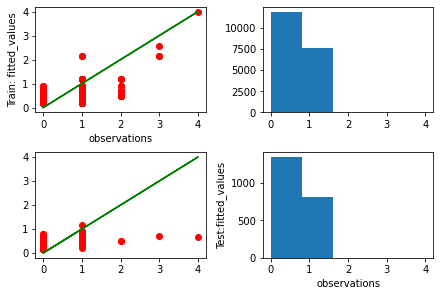

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2 )
ada_regr.fit(X_train, target_train)
y_ada_pred_train = ada_regr.predict(X_train)
y_ada_pred_test = ada_regr.predict(X_test)


ax[0, 0].plot(target_train, y_ada_pred_train, 'o' ,color = 'red')
ax[0, 0].plot(target_train, target_train, color = 'green')
ax[0,0].set_xlabel('observations')
ax[0,0].set_ylabel('Train: fitted_values')
ax[0, 1].hist(target_train, bins = 5)
ax[1, 0].plot(target_test, y_ada_pred_test,'o',  color = 'red')
ax[1, 0].plot(target_test, target_test, color = 'green')
ax[1, 1].hist(target_test, bins = 5)
ax[1,0].set_xlabel('observations')
ax[1,0].set_ylabel('Test:fitted_values')


The performance of the AdaBoost Regressor on the Test set is not significantly better than the Tweedie Distribution ( Power = 1.5) on the same Test set.

In [ ]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100, max_depth = 10, ccp_alpha = 0)
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

cross_val_score(rf, X_train, target_train, cv = 3, scoring = 'neg_mean_squared_error')
rf.fit(X_train, target_train)
y_rf_pred_train = rf.predict(X_train)
y_rf_pred_tst = rf.predict(X_test)
mean_squared_error(target_test, y_rf_pred_tst)



0.13694178154545866

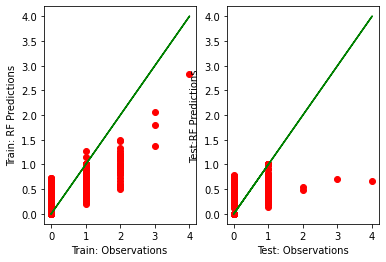

In [ ]:
import matplotlib.pyplot as plt
fig , ax = plt.subplots(1,2)
plt.rcParams['figure.constrained_layout.use'] = True
ax[0].plot(target_train, y_rf_pred_train, 'o', color = 'red')
ax[0].plot(target_train, target_train, color = 'green')
ax[0].set_xlabel('Train: Observations ')
ax[0].set_ylabel("Train: RF Predictions")
ax[1].plot(target_test, y_rf_pred_tst, 'o', color = 'red')
ax[1].plot(target_test, target_test, color = 'green')
ax[1].set_xlabel("Test: Observations")
ax[1].set_ylabel("Test:RF Predictions")
plt.show()
